# Sex prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [84]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot
from utilities import montecarlo_crossvalidation
from utilities import gridsearch_bias
from utilities import model_optimization
from utilities import variable_importance_df



In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')

In [5]:
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [6]:
tsetse_data_copy = tsetse_data.copy()

In [7]:
df_ic = pd.DataFrame(tsetse_data_copy.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue                    
f   3d  Abdomen                 48
        Head                   133
        Thorax                 136
        ThoraxAbdomen20230206    1
    5w  Abdomen                 16
        Head                    92
        Thorax                  96
    7w  Abdomen                 38
        Head                   120
        Thorax                 122
m   5w  Head                    94
        Thorax                  93
    7w  Abdomen                 15
        Head                    93
        Thorax                  92

In [8]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

In [9]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_sameage = tsetse_data_sameages_copy[dList]
tsetse_data_sameages_copy.drop(dList, axis=1,inplace=True)

In [10]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data[dList]
tsetse_data.drop(dList, axis=1,inplace=True)



## Sex prediction

In [11]:
tsetse_thorax = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_copy.loc[descriptorsDF['Tissue'] == 'Head']

In [12]:
tsetse_head.groupby("Sex")["ID"].count()

Sex
f    345
m    187
Name: ID, dtype: int64

In [13]:
X_thorax = tsetse_thorax.loc[:,"1800":"602"]
y_thorax = tsetse_thorax.loc[:,"Sex"]

X_head = tsetse_head.loc[:,"1800":"602"]
y_head = tsetse_head.loc[:,"Sex"]

In [14]:
wnLabels= X_thorax.columns.values.tolist() #wavenumbers labels
waveNums = [int(x) for x in wnLabels] #wavenumbers numbers (for plotting)

In [15]:
thorax_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']

thorax_labels_age = thorax_labels['Age']
thorax_labels_age

274     5w
276     5w
278     5w
280     5w
282     5w
        ..
1180    5w
1182    5w
1184    5w
1186    5w
1188    5w
Name: Age, Length: 403, dtype: object

In [16]:
tsetse_data_head = tsetse_data_sameages[tsetse_data_sameages["Tissue"] == 'Head']

tsetse_data_head_copy = tsetse_data_head.copy()

In [17]:
y_labels = descriptorsDF_sameage[descriptorsDF_sameage['Tissue'] == 'Thorax']['Sex']

In [18]:
y_labels.value_counts()

Sex
f    218
m    185
Name: count, dtype: int64

In [19]:
# Split tain and test

X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [20]:
print(X_hd_train.shape)
print(X_hd_test.shape)

print(X_th_train.shape)
print(X_th_test.shape)

(425, 600)
(107, 600)
(431, 600)
(108, 600)


In [21]:
shape_data = {"train_head": X_hd_train.shape,
              "train_thorax": X_th_train.shape,
              "test_head": X_hd_test.shape,
              "tsetse_thorax":X_th_test.shape}

In [22]:
shape_data_df = pd.DataFrame(shape_data,index=['samples','features'])

shape_data_df

,train_head,train_thorax,test_head,tsetse_thorax
samples,425,431,107,108
features,600,600,600,600


In [22]:
shape_data_df.to_excel("../results/tables/informative_region_results/train_test_shape_sex_informative.xlsx")

In [23]:
# baseline accuracy for head and thorax

thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [24]:
data_plot_thorax = dataplotmelt(thorax_acc_baseline)
data_plot_head = dataplotmelt(head_acc_baseline)

<Axes: xlabel='param_clf', ylabel='value'>

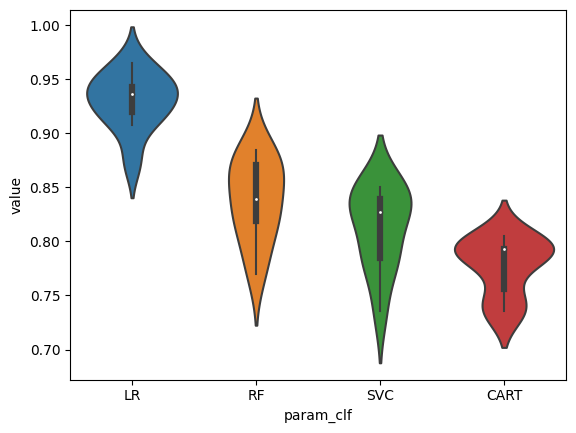

In [25]:
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value')

In [78]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.800000  0.041502
1        LR  0.951765  0.016121
2        RF  0.868235  0.031762
3       SVC  0.894118  0.021479


In [77]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.777011  0.026655
1        LR  0.929885  0.026239
2        RF  0.837931  0.037716
3       SVC  0.812644  0.037948


In [26]:
# optimization

bestmodel_head = model_optimization(X_hd_train,y_hd_train)
bestmodel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [27]:
# test head and thorax

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, bestmodel_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, bestmodel_thorax)

In [28]:
# final accuracy head and thorax on test set

accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9532710280373832
Accuracy on test set: 0.9444444444444444


In [29]:
# classification report head

report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
f,0.961039,0.973684,0.967320,76.000000
m,0.933333,0.903226,0.918033,31.000000
accuracy,0.953271,0.953271,0.953271,0.953271
macro avg,0.947186,0.938455,0.942677,107.000000
weighted avg,0.953012,0.953271,0.953041,107.000000


In [51]:
report_head.to_excel("../results/tables/informative_region_results//accuracy_sex_head.xlsx")

In [36]:
# classification report thorax

report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
f,0.958904,0.958904,0.958904,73.000000
m,0.914286,0.914286,0.914286,35.000000
accuracy,0.944444,0.944444,0.944444,0.944444
macro avg,0.936595,0.936595,0.936595,108.000000
weighted avg,0.944444,0.944444,0.944444,108.000000


In [52]:
report_thorax.to_excel("../results/tables/informative_region_results/accuracy_sex_thorax.xlsx")

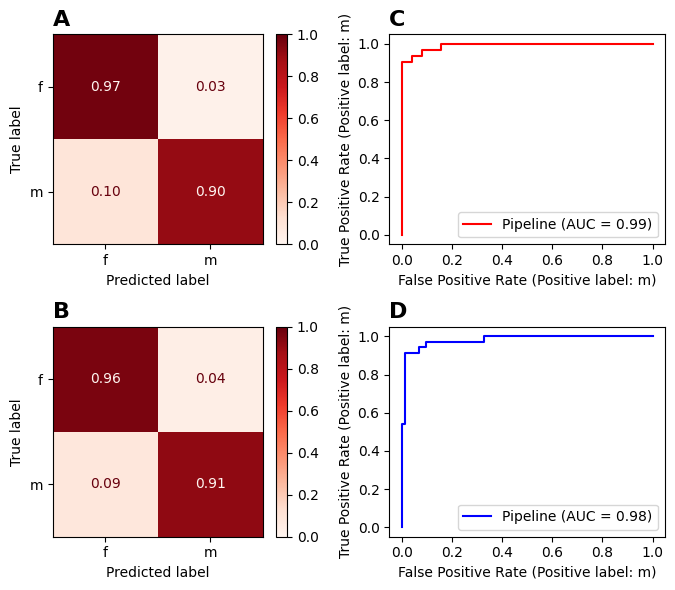

In [30]:
fig, ((ax2, ax5),(ax4, ax6)) = plt.subplots(2,2,figsize=(7,6))

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


RocCurveDisplay.from_estimator(pipe_head, X=X_hd_test, y=y_hd_test, ax=ax5, color='r')

RocCurveDisplay.from_estimator(pipe_thorax, X=X_th_test, y=y_th_test, ax=ax6, color='b')

sizeletters = 16

ax2.set_title("A", loc='left', weight='bold', size=sizeletters)
ax4.set_title("B", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("D", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

#plt.savefig("../results/plots/sex_prediction.png", dpi=300)


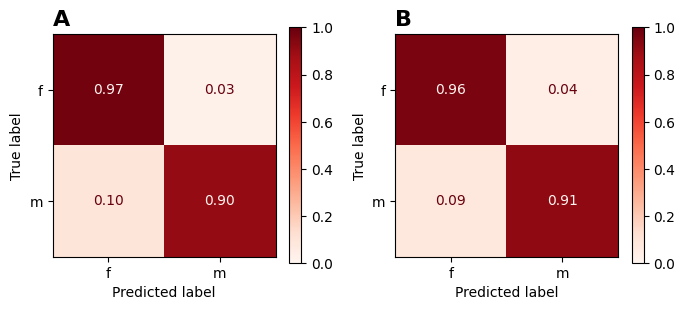

In [31]:
fig, (ax2,ax4) = plt.subplots(1,2,figsize=(7,3))

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})



sizeletters = 16

ax2.set_title("A", loc='left', weight='bold', size=sizeletters)
ax4.set_title("B", loc='left', weight='bold', size=sizeletters)


plt.tight_layout()

#plt.savefig("../results/plots/sex_prediction.png", dpi=300)

In [32]:
top20_head = variable_importance_df(waveNums, bestmodel_head)
top20_thorax = variable_importance_df(waveNums, bestmodel_thorax)

<Axes: title={'center': 'Head'}, xlabel='Wavenumbers', ylabel='Coefficients'>

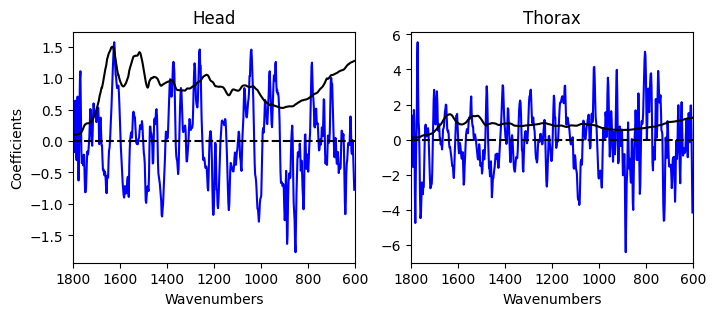

In [33]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,3),sharex=True)

sn.lineplot(x=waveNums,y=bestmodel_head['model'].coef_[0], color='b',ax=ax)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)),color='k',alpha=0.5,ax=ax)
ax.axhline(y=0, color="k", ls="--")
ax.set_xlim(1800,600)
#ax.annotate('1464', xy=(1464,0.4214), xycoords='data',fontsize=10)
#ax.annotate('1678', xy=(1678,0.3214), xycoords='data',fontsize=10)
#ax.annotate('816', xy=(816,0.344), xycoords='data',fontsize=10)
#ax.annotate('1400', xy=(1464,-0.45), xycoords='data',fontsize=10)
#ax.annotate('1562', xy=(1562,-0.42), xycoords='data',fontsize=10)
ax.set_xlabel("Wavenumbers")
ax.set_ylabel("Coefficients")
ax.set_title("Head")


sn.lineplot(x=waveNums,y=bestmodel_thorax['model'].coef_[0], color='b',ax=ax2)
#sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*6),color='k',alpha=0.5,ax=ax2)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlabel("Wavenumbers")
ax2.set_title("Thorax")
#ax2.annotate('782', xy=(782,3.59), xycoords='data',fontsize=10)
#ax2.annotate('1750', xy=(1750,3.214), xycoords='data',fontsize=10)
#ax2.annotate('1464', xy=(1464,3.44), xycoords='data',fontsize=10)
#ax2.annotate('1692', xy=(1692, 2.785488), xycoords='data',fontsize=10)
#ax2.annotate('772', xy=(772,-2.59), xycoords='data',fontsize=10)

#ax2.annotate('686', xy=(686,	-2.576248), xycoords='data',fontsize=10)
#ax2.annotate('1720', xy=(1720, -2.324863), xycoords='data',fontsize=10)

#ax2.annotate('1040', xy=(1040,-2.260752), xycoords='data',fontsize=10)

sn.lineplot(x=waveNums, y=(np.mean(X_thorax ,axis=0)*5),color='k',ax=ax2)
sn.lineplot(x=waveNums, y=(np.mean(X_head ,axis=0)*5),color='k',ax=ax)

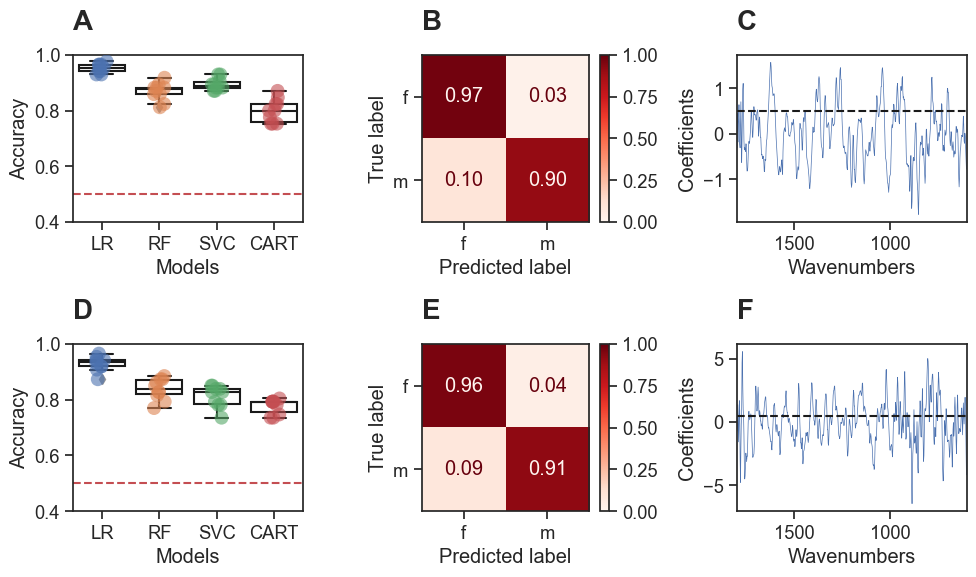

In [34]:
# final model
# settings

sn.set_palette('bright', color_codes=True)
sn.set(font_scale=1.2)
sn.set_style("ticks")

fig, ((ax,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,6), tight_layout=True)

#boxplots
sn.boxplot(data_plot_head,x='param_clf', y='value', ax=ax,color='white')
sn.stripplot(data_plot_head,x='param_clf', y='value',ax=ax, alpha=0.6, hue='param_clf',legend=False,size=10)

sn.boxplot(data_plot_thorax,x='param_clf', y='value', color='white', ax=ax4)
sn.stripplot(data_plot_thorax, x='param_clf', y='value',hue='param_clf', size=10, alpha=0.6, ax=ax4, legend=False)

plt.setp(ax.lines, color='k')
plt.setp(ax4.lines, color='k')

for i, box in enumerate(ax.patches):
    box.set_edgecolor(color='k')

for i, box in enumerate(ax4.patches):
    box.set_edgecolor(color='k')

axes1 = [ax,ax4]
for i in axes1:
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")
    i.axhline(0.5, ls="--",color='r')


# coefficients
sn.lineplot(x=waveNums,y=bestmodel_head['model'].coef_[0], color='b',ax=ax3, linewidth=0.5)
sn.lineplot(x=waveNums,y=bestmodel_thorax['model'].coef_[0], color='b',ax=ax6,linewidth=0.5)

axes1 = [ax3,ax6]
for i in axes1:
    i.set_xlim(1800,600)
    i.set_xlabel("Wavenumbers")
    i.set_ylabel("Coefficients")
    i.axhline(0.5, ls="--",color='k')


# confusion matrices
disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, im_kw={'vmin':0, 'vmax':1})

# final touches

axes1 = [ax,ax2,ax3,ax4,ax5,ax6]
labeles = ["A", "B", "C","D","E","F","G"]
for a, l in zip(axes1, labeles):
    a.set_title(l, y=1.1, loc='left', fontweight='bold', fontsize=20 )


#fig.savefig("../results/plots/informative_region/sex_predictions.png", bbox_inches="tight", dpi=900)



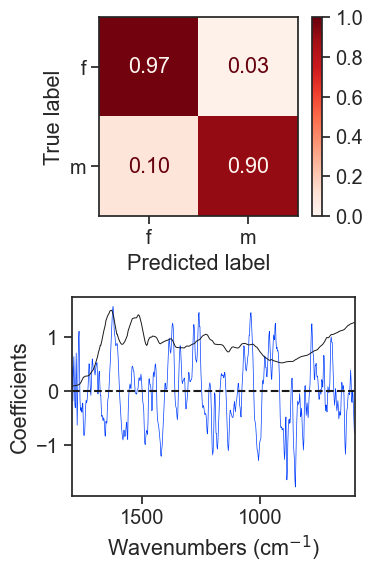

In [83]:
# Final plot paper
# confusion matrix for head and model coefficients

sn.set(font_scale=1.3)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(2,1, figsize=(4,6), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=waveNums,y=bestmodel_head['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)

sn.lineplot(x=waveNums, y=(np.mean(X_head ,axis=0)*5),color='k',ax=ax2, linewidth=0.7)


ax2.set_xlim(1800,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.axhline(0, ls="--",color='k')

plt.savefig("../results/plots/final_plots/sex_prediction_testset_informative.png", dpi=900)


In [79]:
top20_head = variable_importance_df(waveNums, bestmodel_head)

top20_head

,Wavenumbers,Coefficients
88,1624,1.570150
87,1626,1.509933
89,1622,1.470384
270,1260,1.454665
380,1040,1.452318
379,1042,1.426366
269,1262,1.401951
86,1628,1.343792
381,1038,1.314279
378,1044,1.288745


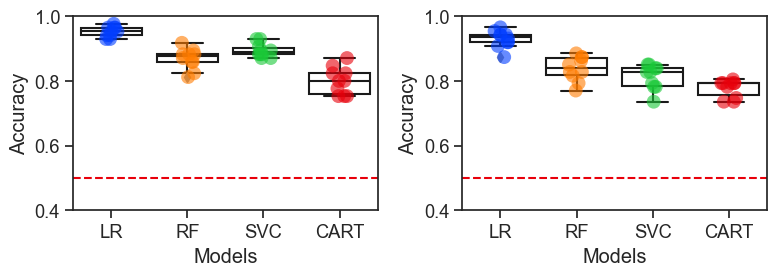

In [73]:
# Final plot suplementary
# here will be training resuslts for head and thorax
# test set results for thorax (confusion matrix) and coefficients

# final model
# settings

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax,ax2)) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

#boxplots
sn.boxplot(data_plot_head,x='param_clf', y='value', ax=ax,color='white')
sn.stripplot(data_plot_head,x='param_clf', y='value',ax=ax, alpha=0.6, hue='param_clf',legend=False,size=10)

sn.boxplot(data_plot_thorax,x='param_clf', y='value', color='white', ax=ax2)
sn.stripplot(data_plot_thorax, x='param_clf', y='value',hue='param_clf', size=10, alpha=0.6, ax=ax2, legend=False)

plt.setp(ax.lines, color='k')
plt.setp(ax2.lines, color='k')

for i, box in enumerate(ax.patches):
    box.set_edgecolor(color='k')

for i, box in enumerate(ax2.patches):
    box.set_edgecolor(color='k')

axes1 = [ax,ax2]
for i in axes1:
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")
    i.axhline(0.5, ls="--",color='r')


# coefficients
sn.lineplot(x=waveNums,y=bestmodel_head['model'].coef_[0], color='b',ax=ax3, linewidth=0.5)
sn.lineplot(x=waveNums,y=bestmodel_thorax['model'].coef_[0], color='b',ax=ax6,linewidth=0.5)

axes1 = [ax3,ax6]
for i in axes1:
    i.set_xlim(1800,600)
    i.set_xlabel("Wavenumbers")
    i.set_ylabel("Coefficients")
    i.axhline(0.5, ls="--",color='k')


plt.savefig("../results/plots/final_plots/sex_prediction_training.png", dpi=900)


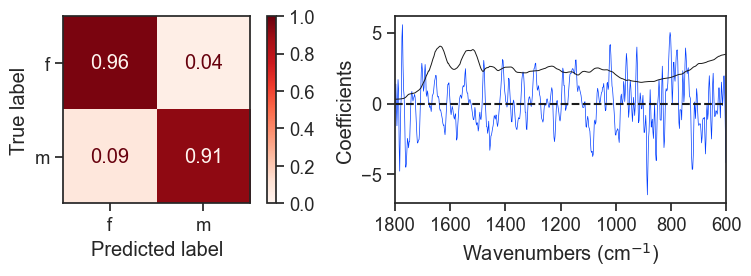

In [74]:
# Final plot paper
# confusion matrix for head and model coefficients

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=waveNums,y=bestmodel_thorax['model'].coef_[0], color='b',ax=ax2, linewidth=0.5)

sn.lineplot(x=waveNums, y=(np.mean(X_thorax ,axis=0)*14),color='k',ax=ax2, linewidth=0.7)


ax2.set_xlim(1800,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.axhline(0, ls="--",color='k')

plt.savefig("../results/plots/final_plots/sex_prediction_thorax.png", dpi=900)

In [85]:
# roc test set head and thorax se prediction
auc_roc_results = pd.DataFrame({"ROC value": [roc_auc_score(y_hd_test, pipe_head.predict_proba(X_hd_test)[:,1]), roc_auc_score(y_th_test, pipe_thorax.predict_proba(X_th_test)[:,1])]},index=['head','thorax'])

print(auc_roc_results)

        ROC value
head     0.991087
thorax   0.980822
